In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# Neural Network implementation with Matrices #4: Parametrised Algorhytm (step by step)

So far, we have been describing the implementation of a neural network with a pre-specified size (the neural network architecture was hard-coded in respect to the number of layers and neurons in each). Here, we will implement an algorithm that can train a neural network of a flexible size in terms of the number of layers and neurons therein.

In this first example, the data and the labels will remain the same as in the previous examples:

In [2]:
data = np.array([[ 1.2, 0.7],
                 [-0.3,-0.5],
                 [ 3.0, 0.1],
                 [-0.1,-1.0],
                 [-0.0, 1.1],
                 [ 2.1,-1.3],
                 [ 3.1,-1.8],
                 [ 1.1,-0.1],
                 [ 1.5,-2.2],
                 [ 4.0,-1.0]])

In [3]:
labels = np.array([  1,
                    -1,
                     1,
                    -1,
                    -1,
                     1,
                    -1,
                     1,
                    -1,
                    -1])

In [4]:
def plot_data(data, labels):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.scatter(data[:,0], data[:,1], c=labels, s=50,  cmap=plt.cm.bwr,zorder=50)
    nudge = 0.08
    for i, (X,Y) in enumerate(data):
        ax.annotate(f'{i}',(X+nudge,Y+nudge))
    ax.set_aspect('equal', 'datalim')
    plt.show()

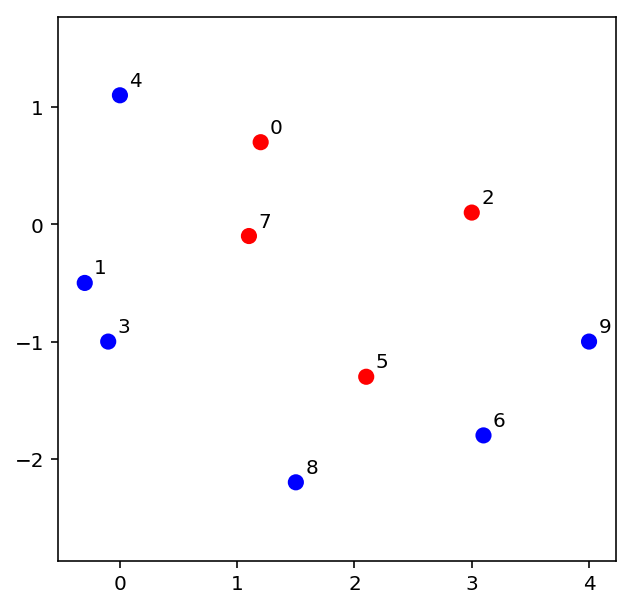

In [5]:
plot_data(data, labels)

## Transformation of the data in the matrix format

Every layer's activation in a neural network is a matrix whose number of rows equals the number of neurons in the layer. Our data should follow the same conventions, such that each data point's row represent an input neurons. Currently our data set represents data points vectors as row vectors. We need to transform them into column vectors, which is done in the next step:

In [6]:
data_vectors = np.array([d.reshape(1,2).T for d in data])
data_vectors

array([[[ 1.2],
        [ 0.7]],

       [[-0.3],
        [-0.5]],

       [[ 3. ],
        [ 0.1]],

       [[-0.1],
        [-1. ]],

       [[-0. ],
        [ 1.1]],

       [[ 2.1],
        [-1.3]],

       [[ 3.1],
        [-1.8]],

       [[ 1.1],
        [-0.1]],

       [[ 1.5],
        [-2.2]],

       [[ 4. ],
        [-1. ]]])

To compute the cost for a single example we need to subtract the values of the labels from the values of the final activations. For that purpose, it is useful that the labels are also represented as column matrices. We can transform the labels into column vectors with the following code:

In [7]:
labels_vector = np.array([np.array([1,0]).reshape(1,2).T if l==-1 
          else np.array([0,1]).reshape(1,2).T if l==1 
          else None 
          for l in labels])
labels_vector

array([[[0],
        [1]],

       [[1],
        [0]],

       [[0],
        [1]],

       [[1],
        [0]],

       [[1],
        [0]],

       [[0],
        [1]],

       [[1],
        [0]],

       [[0],
        [1]],

       [[1],
        [0]],

       [[1],
        [0]]])

## Encoding of the neural network's size

First we will define the variable sizes and use it to define the size of the neural network. The number of elements in the list defines how many layers there are, and the numbers themselves stand for the number of neurons in the current layer. For example, if our network has 3 layers in total: 
- 2 neurons in the input layer
- 3 neurons in the hidden layer and 
- 2 outputs in the outer layer

we can encode it as `[2,3,2]`.

In [8]:
sizes = [2,3,2]
sizes

[2, 3, 2]

### Initialising the weights and biases

#### Biases

We know that the input layer of the neural network is not parametrised by weights and biases. Therefore we need to create bias matrices only for the hidden layer(s) and the output layer. We can select them by `sizes[1:]`. 

In [9]:
sizes[1:]

[3, 2]

A bias matrix has only a single column since each neuron has only one bias (its shape is `y`-rows, `1`-columns). This makes it very easy to create a list of all the biases in the network in one go:

In [10]:
biases = [np.random.randn(y, 1) for y in sizes[1:]]
# print
for b in biases:
    print (f'{b}\n')

[[-0.387]
 [ 0.59 ]
 [ 0.323]]

[[ 1.004]
 [-0.204]]



#### Weights

To compute all the weights at once we need to know in advance the number of rows and columns in every layer. In the last class we learned that the number of rows in a weight matrix corresponds to the number of neurons in that layer. The number of columns correspond to the number of neurons in the previous layer. To obtain the number of rows (neurons) for each layer except the input layer, we can use `sizes[1:]`.

In [11]:
sizes[1:]

[3, 2]

To obtain the number of rows (neurons) of the previous layers in respect to the last operation, we can use `sizes[:-1]`.

In [12]:
sizes[:-1]

[2, 3]

To compute the sizes of all the weight matrices we only need to combine these two lists together by using `zip` function:

In [13]:
for i, (x, y) in enumerate(zip(sizes[1:], sizes[:-1])):
    print (f'layer {i+2}:  {x} rows, {y} columns ---> {x,y}')

layer 2:  3 rows, 2 columns ---> (3, 2)
layer 3:  2 rows, 3 columns ---> (2, 3)


This allows us to create all the weight matrices at once:

In [14]:
weights = [np.random.randn(x, y) for x, y in zip(sizes[1:], sizes[:-1])]
# print
for w in weights:
    print (f'{w}\n')

[[-2.876  0.898]
 [-1.403 -1.445]
 [-1.602 -1.016]]

[[-0.899  0.392  0.352]
 [ 0.28  -0.92   0.357]]



### Storing the derivatives

Now the two variables `weights` and `biases` store all the weights and biases matrices. It would be very useful to store the partial derivatives of weights and biases in the same form. For that we will create two new variables `d_weights` and `d_biases` that will have the same size as their counterparts.

In [15]:
d_biases = [np.zeros(b.shape) for b in biases]
# print
print ("biases:")
for b in d_biases:
    print (f'{b}\n')
    
    
d_weights = [np.zeros(w.shape) for w in weights]
# print
print ("weights:")
for w in d_weights:
    print (f'{w}\n')

biases:
[[0.]
 [0.]
 [0.]]

[[0.]
 [0.]]

weights:
[[0. 0.]
 [0. 0.]
 [0. 0.]]

[[0. 0. 0.]
 [0. 0. 0.]]



## Computation of the forward pass

First, let's define a sigmoid function:

In [16]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

To calculate a forward pass, we will use a single data point, later we will use more points and average their activaitons.

In [17]:
data_point = data_vectors[0]
data_point

array([[1.2],
       [0.7]])

We will now compute the whole feed forward pass in one go, storing weighted sums and activations within each layer. As before, the data point will be interpreted as the activation of the first (input) layer that is not parametrised by weights and biases.

In [19]:
# the neuron activation will change as we progress through layer
# but it starts as a data point in our first layer
a = data_point # current activation
activations = [data_point] # here we store all the activations, layer by layer
weighted_sums = [] # here we store all the weighted sums, layer by layer
for b, w in zip(biases, weights):
    w_sum = np.dot(w, a)+b #current weighted sum
    weighted_sums.append(w_sum) 
    a = sigmoid(w_sum) # current activation is updated and then the loop goes to the next layer
    activations.append(a)

We can print all the values of the weighted sums:

In [20]:
for ws in weighted_sums:
    print (f'{ws}\n')

[[-3.209]
 [-2.105]
 [-2.311]]

[[ 1.043]
 [-0.261]]



We can also print all the activation values layer by layer. **Note that first activation is the same as our data point.**

In [21]:
for a in activations:
    print (f'{a}\n')

[[1.2]
 [0.7]]

[[0.039]
 [0.109]
 [0.09 ]]

[[0.739]
 [0.435]]



## Computation of the cost

Since we are working with the data_point with the index `0`, its corresponding label that we will name `current_label` will also have the same index:

In [22]:
current_label = labels_vector[0]
current_label

array([[0],
       [1]])

Here we compute the cost/loss for the current data point:

In [23]:
cost = sum((data_point - activations[-1])**2)[0]
print (f"The cost is: {cost}")

The cost is: 0.28221910236602477


## Computation of the backward pass

The general strategy is that in the first step we compute the partial derivatives in respect to the weights and biases in the output layer, an in the second step all the rest of them.

#### Derivatives of weights and biases in the output layer

Here we compute the partial derivative of the total cost in respect to the weighted sums of the output layer:

In [24]:
# derivative of the total cost in respect to the output activations 
# * 
# derivative of the output activations in respect to the weighted sums
d_w_sum = (activations[-1]-current_label) * (activations[-1] * (1-activations[-1])) 
d_w_sum

array([[ 0.142],
       [-0.139]])

Once we know the derivative of the total cost in respect to the weighted sums, it is easy to compute the derivatives of the weights and the biases of the output layer. The derivative of the biases will be the same as the derivatives for the weighted sums, and for the weights, we need to multiply the derivatives of the weighted sums with the transposed activation matrix from the level before the last (output).

In [26]:
d_biases[-1] = d_w_sum
d_weights[-1] = np.dot(d_w_sum, activations[-2].transpose())

If we preview the weights and biases matrices, we will see that only the last matrices are filled in, while the rest is still equal to zero.

In [27]:
for d in d_weights:
    print (f'{d}\n')

[[0. 0.]
 [0. 0.]
 [0. 0.]]

[[ 0.006  0.015  0.013]
 [-0.005 -0.015 -0.013]]



In [28]:
for b in d_biases:
    print (f'{b}\n')

[[0.]
 [0.]
 [0.]]

[[ 0.142]
 [-0.139]]



#### Derivatives of weights and biases in the hidden layers

Now we ought to compute the partial derivatives in respect to the weights and biases of all the layers expect the output layer in one single step. For that, we first determine the number of layers of the neural network:

In [29]:
num_layers = len(sizes)
print (f"The number of layers is: {num_layers}")

The number of layers is: 3


Then we iterate through the layers backwards by using the negative value of the iterator `[-i]` starting with the second from the back and ending to the second one from the start.

In [30]:
for i in range(2, num_layers):
    act = activations[-i]
    d_w_sum = np.dot(weights[-i+1].T, d_w_sum) * (act * (1 - act))
    d_biases[-i] = d_w_sum
    d_weights[-i] = np.dot(d_w_sum, activations[-i-1].T)

If we now print the weigths and biases matrices, we will see that all the values are filled in:

In [31]:
for d in d_weights:
    print (f'{d}\n')

[[-0.007 -0.004]
 [ 0.021  0.012]
 [ 0.     0.   ]]

[[ 0.006  0.015  0.013]
 [-0.005 -0.015 -0.013]]



In [32]:
for b in d_biases:
    print (f'{b}\n')

[[-0.006]
 [ 0.018]
 [ 0.   ]]

[[ 0.142]
 [-0.139]]



## Updating the weights and biases

To update the weights and biases with we need to subtract the newly computed derivatives from the original values in order to minimise our cost function. In order to minimise the function slowly, we will multiply the values of partial derivatives with a small number, defined with the variable `step_size`.

In [33]:
step_size = 0.1

In [34]:
weights = [w - (step_size * dw) 
           for w, dw in zip(weights, d_weights)]

biases =  [b - (step_size * db)
          for b, db in zip(biases, d_biases)]

Now we can print the updated values of the weights and biases:

In [35]:
for d in d_weights:
    print (f'{d}\n')

[[-0.007 -0.004]
 [ 0.021  0.012]
 [ 0.     0.   ]]

[[ 0.006  0.015  0.013]
 [-0.005 -0.015 -0.013]]



In [36]:
for b in d_biases:
    print (f'{b}\n')

[[-0.006]
 [ 0.018]
 [ 0.   ]]

[[ 0.142]
 [-0.139]]

